<a href="https://colab.research.google.com/github/DonnaVakalis/Urban.dat/blob/master/maml_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone Project

 

## Table of Contents
- [Introduction](#intro)
- [Part I - Gather Data](#partone)
- [Part II - Handle Categorical and Missing Data ](#parttwo)
- [Part III -Q1: Analysis & Visualization ](#partthree)
- [Part IV -Q2: Analysis & Visualization ](#partfour)
- [Part V -Q3: Analysis & Visualization ](#partfive)




<a id='intro'></a>
### Introduction

This notebook gathers, assesses then analyses some data from a global dataset of CO2 emissions:
Nangini, C., Peregon, A., Ciais, P. et al. A global dataset of CO2 emissions and ancillary data related to emissions for 343 cities. Sci Data 6, 180280 (2019). https://doi.org/10.1038/sdata.2018.280


Three main questions: 

1.   What cities participate in reporting? Do they have certain things in common? (would have to bring in data from non-reporting cities to see this...) 
2.   I've heard that urban density is more environmentally responsible: among these cities what is the relationship between density and per capita emissions?
3.   Is there an identifiable 'main driver' of emissions across all cities? Like a certain sector? 

Along the way, through comments I will provide insight into the methods I chose and why I chose them. I will also provide a connection between my three questions and how the data answers them...
__________

<a id='partone'></a>
# Part I - Setup

## Import libraries, mount drive and load raw datasets

In [63]:
# import libraries

 
import os
from google.colab import drive

import pandas as pd # for everything! 
import numpy as np # diddo
import datetime # for comparing issuance/filing/expiration dates
import matplotlib.pyplot as plt # for visualizing answers

import statsmodels.formula.api as smf # for writing models like in R :)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Data source: https://doi.pangaea.de/10.1594/PANGAEA.884141

# Downloaded this file manually 
''' Description here..
''' 

# Point to the folder for this project 
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/Udacity_DataScience/" 


# Load data into Pandas

dat = pd.read_excel(
  DATA_PATH+'D_FINAL.xlsx' 
  #index_col=False,
  #dtype=COLUMN_NAMES
)

Mounted at /content/gdrive


· info()
· describe()
· value_counts()
· nunique()
· sum()
· count()
· min(), max(), mean(), and median()
· agg()
· groupby()

In [84]:
pd.set_option('display.max_columns', None)
dat.sample(1)

,Unnamed: 0,City name,City name (CDP),City name (carbonn),City name (PKU),City name (GEA),City name (UITP),City name (WB),Definition (CDP),Definition (carbonn),Definition (WB),Study year (WB),Reporting year (CDP),Scope-1 GHG emissions [tCO2 or tCO2-eq],Scope-1 source dataset,Scope-1 GHG emissions units,Year of emission,Emissions protocol,Gases included (CDP),Methodology details (CDP),Increase/Decrease from last year (CDP),Reason for increase/decrease in emissions (CDP),Scope-2 (CDP) [tCO2-eq],Total emissions (CDP) [tCO2-eq],CDP2016 data edited (CDP),Emissions Quality Flag (CDP),S1 lower bound [tCO2] (CDP),S1 upper bound [tCO2] (CDP),S1 mean (CDP) [tCO2],TOT lower bound [tCO2] (CDP),TOT upper bound [tCO2] (CDP),TOT mean (CDP) [tCO2],Scope fraction (CDP),CO2 emissions per capita (PKU) [tCO2/capita],City location (CDP) [degrees],Latitude (others) [degrees],Longitude (others) [degrees],Coordinate source (others),Country,Region,Population (CDP),Population year (CDP),Population (carbonn),Population year (carbonn),Urban population (PKU),Population (GEA),Population (UITP),Population (WB),Population year (WB),Population (others),Population year (others),Population source (others),Population 1950 (WB),Population 1990 (WB),Population 2010 (WB),Population growth rate 1950-2010 (WB) [people/60years],Population growth rate 1990-2010 (WB) [people/20years],Ancillary from GEA+,City area (CDP) [km2],City area (GEA) [km2],City area (WB) [km2],Built-up area (PKU) [km2],City area (others) [km2],City area source year (others),City area source (others),Population density (GEA) [people/km2],Population density (UITP) [people/km2],Population density (WB) [people/km2],Population/sqrt(area) (GEA) [people/km],Population/sqrt(area) (WB) [people/km],Average altitude [m],Average annual temperature (CDP) [degrees Celsius],Weather station ID (GEA+),CDD 23C (GEA+) [degrees C × days],HDD 15.5C (GEA+) [degrees C × days],HDD 15.5C (clim) [degrees C × days],CDD 23C (clim) [degrees C × days],GDP (CDP) [multiple units],GDP unit (CDP),GDP year (CDP),GDP source (CDP),GDP (carbonn) [multiple units],nGDP (carbonn) [multiple units],GDP unit (carbonn),GDP year (carbonn),GDP (PKU) [10000 RMB],Income per capita (PKU) [RMB/capita],GDP-PPP (others) [$BN],GDP-PPP/capita (others) [USD/capita],GDP-PPP source (others),GDP-PPP year (others),nGDP (others) [$BN],nGDP/capita (others) [USD/capita],nGDP source (others),nGDP year (others),GDP-PPP/capita (GEA) [USD/year],GDP-PPP/capita (UITP) [USD/year],GDP-PPP/capita (WB) [USD/year],Total final consumption per capita (GEA) [GJ/capita/yr],Energy per capita CO2 (WB) [tCO2-eq/capita/yr],Diesel price (GEA+) [USD/liter],Gasoline price (GEA+) [USD/liter],Center of commerce index (GEA+) [dimensionless],Household size (GEA+) [people/household],Household size year (GEA+),Household source (GEA+),Household size comment (GEA+),Urbanization ratio (GEA+) [percent],Water bounded (GEA+),Other bounded (GEA+),Mean one-way travel time (others) [minutes],Mean one-way travel time year (others),Mean one-way travel time source (others),Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Household size (others) [people/household],Household size year (others),Household size source (others),Household size comment (others),Congestion rank (INRIX) [dimensionless],Peak hours spent in congestion (INRIX) [hours],INRIX congestion index (INRIX) [dimensionless],Average congestion rate (INRIX) [percent],Congestion rank (TomTom) [dimensionless],Congestion level (TomTom) [× 100 percent],Congestion change (TomTom) [× 100 percent],Morning peak (TomTom) [percent],Evening peak (TomTom) [percent],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning 

In [127]:
# 1. Zero-in on the columns of interest:

print('There are', dat.shape[1], 'columns in the original dataframe.')

# get copy-and-pastable list of data names...
# print(dat.columns.tolist())
cols_keep = ['City name', 'Reporting year (CDP)', 'Scope-1 GHG emissions [tCO2 or tCO2-eq]', 'Scope-1 GHG emissions units', 'Year of emission', 'Gases included (CDP)', 'Increase/Decrease from last year (CDP)', 'Scope-2 (CDP) [tCO2-eq]', 
             'Total emissions (CDP) [tCO2-eq]', 'S1 lower bound [tCO2] (CDP)', 'S1 upper bound [tCO2] (CDP)', 'S1 mean (CDP) [tCO2]', 'TOT lower bound [tCO2] (CDP)', 'TOT upper bound [tCO2] (CDP)', 'TOT mean (CDP) [tCO2]', 
             'CO2 emissions per capita (PKU) [tCO2/capita]', 
             'City location (CDP) [degrees]', 'Latitude (others) [degrees]', 'Longitude (others) [degrees]',  'Country', 'Region', 
             'Population (CDP)', 'Population year (CDP)', 'Population (carbonn)', 'Population year (carbonn)', 'Urban population (PKU)', 'Population (GEA)', 'Population (UITP)', 'Population (WB)', 
             #'Population year (WB)', 'Population (others)', 'Population year (others)', 'Population 1950 (WB)', 'Population 1990 (WB)', 'Population 2010 (WB)', 
             'Population growth rate 1950-2010 (WB) [people/60years]', 'Population growth rate 1990-2010 (WB) [people/20years]', 
             'City area (CDP) [km2]', 'City area (GEA) [km2]', 'City area (WB) [km2]', 'Built-up area (PKU) [km2]', 'City area (others) [km2]', 
             #'City area source year (others)', 'City area source (others)', 
             'Population density (GEA) [people/km2]', 'Population density (UITP) [people/km2]', 'Population density (WB) [people/km2]', 'Population/sqrt(area) (GEA) [people/km]', 'Population/sqrt(area) (WB) [people/km]', 
             'Average altitude [m]', 'Average annual temperature (CDP) [degrees Celsius]', 'Weather station ID (GEA+)', 'CDD 23C (GEA+) [degrees C × days]', 'HDD 15.5C (GEA+) [degrees C × days]', 'HDD 15.5C (clim) [degrees C × days]', 'CDD 23C (clim) [degrees C × days]', 
             'GDP (CDP) [multiple units]', 'GDP unit (CDP)', 'GDP (carbonn) [multiple units]', 'nGDP (carbonn) [multiple units]', 'GDP unit (carbonn)', 'GDP (PKU) [10000 RMB]', 
             'Income per capita (PKU) [RMB/capita]', 'GDP-PPP (others) [$BN]', 'GDP-PPP/capita (others) [USD/capita]', 'GDP-PPP year (others)', 'nGDP (others) [$BN]', 'nGDP/capita (others) [USD/capita]', 'nGDP year (others)', 'GDP-PPP/capita (GEA) [USD/year]', 'GDP-PPP/capita (UITP) [USD/year]', 'GDP-PPP/capita (WB) [USD/year]', 
             'Total final consumption per capita (GEA) [GJ/capita/yr]', 'Energy per capita CO2 (WB) [tCO2-eq/capita/yr]', 
             'Diesel price (GEA+) [USD/liter]', 'Gasoline price (GEA+) [USD/liter]', 'Diesel price 2014 (others) [USD/liter]', 'Gasoline price 2014 (others) [USD/liter]',
             'Center of commerce index (GEA+) [dimensionless]', 
             'Household size (GEA+) [people/household]', 'Household size (others) [people/household]', 
             'Urbanization ratio (GEA+) [percent]', 
             'Water bounded (GEA+)', 'Other bounded (GEA+)', 
             'Mean one-way travel time (others) [minutes]', #Mean one-way travel time to travel to work for city citizen
             'Congestion rank (INRIX) [dimensionless]', 'Peak hours spent in congestion (INRIX) [hours]', 'INRIX congestion index (INRIX) [dimensionless]', 'Average congestion rate (INRIX) [percent]', 'Congestion rank (TomTom) [dimensionless]', 'Congestion level (TomTom) [× 100 percent]', 'Congestion change (TomTom) [× 100 percent]', 'Morning peak (TomTom) [percent]', 'Evening peak (TomTom) [percent]', 
             'Economy (IESE) [dimensionless]', 
             'Environment (IESE) [dimensionless]', 
             'Governance (IESE) [dimensionless]', 
             'Human capital (IESE) [dimensionless]', 
             'International impact (IESE) [dimensionless]', 
             'Mobility and transportation (IESE) [dimensionless]', 
             'Public management (IESE) [dimensionless]', 
             'Social cohesion (IESE) [dimensionless]', 
             'Technology (IESE) [dimensionless]', 
             'Urban planning (IESE) [dimensionless]', 
             'CIMI (IESE) [dimensionless]', 'CIMI ranking (IESE) [dimensionless]', 'CIMI performance (IESE) [dimensionless]', 
             'Urban area name (UEX)', 'Low BUA - 1990 (UEX) [km2]', 'Low BUA - 2000 (UEX) [km2]', 'Low BUA - 2014 (UEX) [km2]', 'High BUA - 1990 (UEX) [km2]', 'High BUA - 2000 (UEX) [km2]', 'High BUA - 2014 (UEX) [km2]', 'Low BUA % - 1990 (UEX) [percent]', 'Low BUA % - 2000 (UEX) [percent]', 'Low BUA % - 2014 (UEX) [percent]', 'High BUA % - 1990 (UEX) [percent]', 'High BUA % - 2000 (UEX) [percent]', 'High BUA % - 2014 (UEX) [percent]', 'Low BUA population density - 1990 (UEX) [people/km2]', 'High BUA population density - 1990 (UEX) [people/km2]', 'Low BUA population density - 2000 (UEX) [people/km2]', 'High BUA population density - 2000 (UEX) [people/km2]', 'Low BUA population density - 2014 (UEX) [people/km2]', 'High BUA population density - 2014 (UEX) [people/km2]', # Urban area expansion in units of percentage of total built-up area (BUA) for low and high BUAs reflects the increase in the built environment 
             'Exports (others) [m3]', 'Production (others) [m3]', 'Natgas Export/Production ratio (others)', #Domestic natural gas export/production 
             'CH4_waste/capita (others) [tCH4/capita]', 'CH4_waste+natgas/capita (others) [tCH4/capita]', 'Corrected CH4_(waste+natgas)/capita (others) [tCH4/capita]']

            

print('Keep', dat[cols_keep].shape[1], 'columns of interest to begin with...')

#rename key outcome variables
dat01 = dat[cols_keep].rename(columns={'City name':'city',
                                       'Total final consumption per capita (GEA) [GJ/capita/yr]':'nrg_pp',
                                       'Scope-1 GHG emissions [tCO2 or tCO2-eq]':'co2_tot'})

# Total Co2 is outcome of interest: drop 36 rows that do not report ()
dat01.dropna(axis=0, subset=['co2_tot'], inplace=True)
len(dat01[dat01.co2_tot.isnull()])

# Add a 'feature' to differentiate between Canadian and non-Canadian cities
dat01['is_cad'] = np.where(dat01['Country'] == 'Canada', 1, 0)  


There are 181 columns in the original dataframe.
Keep 124 columns of interest to begin with...


## First quick n' dirty look at the data

In [128]:
# Quick n' dirty exploration of where Canadian cities stand
dat02 = dat01.copy()
print('There are',  dat02.is_cad.value_counts()[1], 'Canadian cities, and ',dat02.is_cad.value_counts()[0] , 'other cities in the data set.') 
#Unfortunately, not enough energy data to ask questions that require knowing this (i.e., total emissions might depend on fuel source, but impossible to know without controlling for underlying energy consumption.)
dat02[dat02.is_cad==1][['city','nrg_pp','co2_tot','Energy per capita CO2 (WB) [tCO2-eq/capita/yr]']]

There are 11 Canadian cities, and  296 other cities in the data set.


,city,nrg_pp,co2_tot,Energy per capita CO2 (WB) [tCO2-eq/capita/yr]
7,"Ajax, ON",NaN,6354.0,NaN
53,Calgary,NaN,10448332.0,17.3
84,Edmonton,NaN,10215142.0,NaN
110,"Hamilton, ON",NaN,6304593.0,NaN
176,"London, ON",NaN,2771000.0,NaN
191,Montreal,NaN,13634331.0,NaN
209,North Vancouver,NaN,182896.0,NaN
294,Toronto,162.915756,16151019.0,9.8
305,Vancouver,NaN,2389748.0,NaN
314,"Windsor, ON",NaN,2475703.0,NaN


In [129]:
mu_co2_cad = dat02.query("is_cad==1")['co2_tot'].mean()
print('Mean Canadian emissions per person:', round(mu_co2_cad), 'tonnes C02e per capita')

mu_co2_other = dat02.query("is_cad==0")['co2_tot'].mean()
print('Mean non-Canadian energy per person:', round(mu_co2_other), 'tonnes C02e per capita')

Mean Canadian emissions per person: 6340597 tonnes C02e per capita
Mean non-Canadian energy per person: 8541075 tonnes C02e per capita


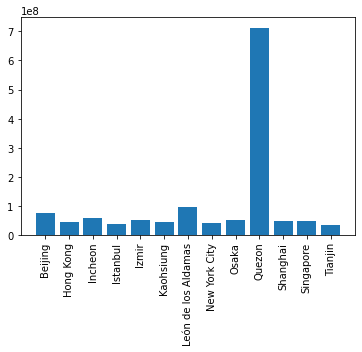

In [121]:
# Why are there super high values and which cities are they from?
outliers = dat02[dat02.co2_tot > 4*mu_co2_other]
plt.bar(outliers['city'],outliers['co2_tot'])
plt.xticks(rotation=90)
plt.show() #Quezon is an outlier...remove during cleaning

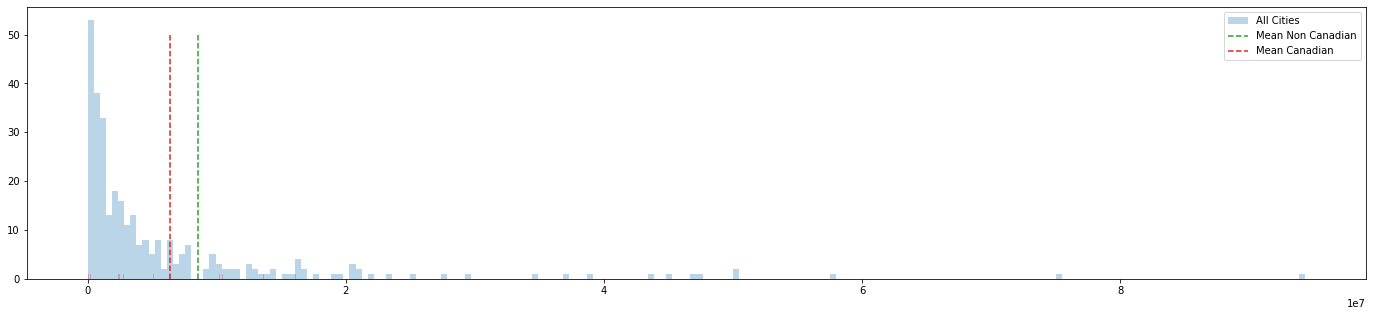

In [130]:
data = dat02[dat02.city != 'Quezon']

plt.figure(figsize=(24,5))  
plt.hist(data["co2_tot"], bins=200, alpha=0.3, label="All Cities")
#plt.hist(data.query("is_cad==0")["co2_tot"], bins=200, alpha=0.3, color="C2")
plt.hist(data.query("is_cad==1")["co2_tot"], bins=200, alpha=0.3, color="C3")
plt.vlines(mu_co2_other, 0, 50, label="Mean Non Canadian",  linestyle='dashed', color="C2")
plt.vlines(mu_co2_cad, 0, 50, label="Mean Canadian",  linestyle='dashed', color="C3")
plt.legend();

## Do some clean up based on initial exploration of data

### Handle missing data

In [131]:
print('Originally, only 66% cities have values for population density, and these are in different columns. Fixing this:')
# funnel multiple methods into single features

# population numbers
dat01['pop'] = np.where(~np.isnan(dat01['Population (CDP)']),dat01['Population (CDP)'],
                                np.where(~np.isnan(dat01['Population (carbonn)']),dat01['Population (carbonn)'],
                                         np.where(~np.isnan(dat01['Urban population (PKU)']),dat01['Urban population (PKU)'], 
                                                  np.where(~np.isnan(dat01['Population (GEA)']),dat01['Population (GEA)'], 
                                                           np.where(~np.isnan(dat01['Population (UITP)']),dat01['Population (UITP)'], 
                                                                    np.where(~np.isnan(dat01['Population (WB)']),dat01['Population (WB)'], np.nan))))))  


# land area numbers
dat01['area'] = np.where(~np.isnan(dat01['City area (CDP) [km2]']),dat01['City area (CDP) [km2]'],
                                np.where(~np.isnan(dat01['City area (GEA) [km2]']),dat01['City area (GEA) [km2]'],
                                         np.where(~np.isnan(dat01['City area (WB) [km2]']),dat01['City area (WB) [km2]'], 
                                                  np.where(~np.isnan(dat01['Built-up area (PKU) [km2]']),dat01['Built-up area (PKU) [km2]'], 
                                                           np.where(~np.isnan(dat01['City area (others) [km2]']),dat01['City area (others) [km2]'], np.nan)))))  



# density
dat01['pop_density'] = np.where(~np.isnan(dat01['Population density (GEA) [people/km2]']),dat01['Population density (GEA) [people/km2]'],
                                np.where(~np.isnan(dat01['Population density (UITP) [people/km2]']),dat01['Population density (UITP) [people/km2]'],
                                         np.where(~np.isnan(dat01['Population density (WB) [people/km2]']),dat01['Population density (WB) [people/km2]'], 
                                                   np.where(~np.isnan(dat01['area']), (dat01['pop']/dat01['area']), np.nan  ))))

print('This leaves just one city (	Guaratinguetá	) in Brazil without data. Will be dropped.')
dat01[dat01.pop_density.isnull()]  

Originally, only 66% cities have values for population density, and these are in different columns. Fixing this:
This leaves just one city (	Guaratinguetá	) in Brazil without data. Will be dropped later.


,city,Reporting year (CDP),co2_tot,Scope-1 GHG emissions units,Year of emission,Gases included (CDP),Increase/Decrease from last year (CDP),Scope-2 (CDP) [tCO2-eq],Total emissions (CDP) [tCO2-eq],S1 lower bound [tCO2] (CDP),S1 upper bound [tCO2] (CDP),S1 mean (CDP) [tCO2],TOT lower bound [tCO2] (CDP),TOT upper bound [tCO2] (CDP),TOT mean (CDP) [tCO2],CO2 emissions per capita (PKU) [tCO2/capita],City location (CDP) [degrees],Latitude (others) [degrees],Longitude (others) [degrees],Country,Region,Population (CDP),Population year (CDP),Population (carbonn),Population year (carbonn),Urban population (PKU),Population (GEA),Population (UITP),Population (WB),Population growth rate 1950-2010 (WB) [people/60years],Population growth rate 1990-2010 (WB) [people/20years],City area (CDP) [km2],City area (GEA) [km2],City area (WB) [km2],Built-up area (PKU) [km2],City area (others) [km2],Population density (GEA) [people/km2],Population density (UITP) [people/km2],Population density (WB) [people/km2],Population/sqrt(area) (GEA) [people/km],Population/sqrt(area) (WB) [people/km],Average altitude [m],Average annual temperature (CDP) [degrees Celsius],Weather station ID (GEA+),CDD 23C (GEA+) [degrees C × days],HDD 15.5C (GEA+) [degrees C × days],HDD 15.5C (clim) [degrees C × days],CDD 23C (clim) [degrees C × days],GDP (CDP) [multiple units],GDP unit (CDP),GDP (carbonn) [multiple units],nGDP (carbonn) [multiple units],GDP unit (carbonn),GDP (PKU) [10000 RMB],Income per capita (PKU) [RMB/capita],GDP-PPP (others) [$BN],GDP-PPP/capita (others) [USD/capita],GDP-PPP year (others),nGDP (others) [$BN],nGDP/capita (others) [USD/capita],nGDP year (others),GDP-PPP/capita (GEA) [USD/year],GDP-PPP/capita (UITP) [USD/year],GDP-PPP/capita (WB) [USD/year],nrg_pp,Energy per capita CO2 (WB) [tCO2-eq/capita/yr],Diesel price (GEA+) [USD/liter],Gasoline price (GEA+) [USD/liter],Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Center of commerce index (GEA+) [dimensionless],Household size (GEA+) [people/household],Household size (others) [people/household],Urbanization ratio (GEA+) [percent],Water bounded (GEA+),Other bounded (GEA+),Mean one-way travel time (others) [minutes],Congestion rank (INRIX) [dimensionless],Peak hours spent in congestion (INRIX) [hours],INRIX congestion index (INRIX) [dimensionless],Average congestion rate (INRIX) [percent],Congestion rank (TomTom) [dimensionless],Congestion level (TomTom) [× 100 percent],Congestion change (TomTom) [× 100 percent],Morning peak (TomTom) [percent],Evening peak (TomTom) [percent],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning (IESE) [dimensionless],CIMI (IESE) [dimensionless],CIMI ranking (IESE) [dimensionless],CIMI performance (IESE) [dimensionless],Urban area name (UEX),Low BUA - 1990 (UEX) [km2],Low BUA - 2000 (UEX) [km2],Low BUA - 2014 (UEX) [km2],High BUA - 1990 (UEX) [km2],High BUA - 2000 (UEX) [km2],High BUA - 2014 (UEX) [km2],Low BUA % - 1990 (UEX) [percent],Low BUA % - 2000 (UEX) [percent],Low BUA % - 2014 (UEX) [percent],High BUA % - 1990 (UEX) [percent],High BUA % - 2000 (UEX) [percent],High BUA % - 2014 (UEX) [percent],Low BUA population density - 1990 (UEX) [people/km2],High BUA population density - 1990 (UEX) [people/km2],Low BUA population density - 2000 (UEX) [people/km2],High BUA population density - 2000 (UEX) [people/km2],Low BUA population density - 2014 (UEX) [people/km2],High BUA population density - 2014 (UEX) [people/km2],Exports (others) [m3],Production (others) [m3],Natgas Export/Production ratio (others),CH4_waste/capita (others) [tCH4/capita],CH4_waste+natgas/capita (others) [tCH4/capita],Corrected CH4_(waste+natgas)/capita (others) [tCH4/capita]

In [ ]:
# Dropping Guaratinguetá (missing density) and Quezon (emissions are extreme outlier)


### Handle categorical data

In [ ]:
# 2. Handle categorical 
# Pull a list of the column names of object variables
obj_cols_lst = dat01.select_dtypes(include=['object']).columns 

print(obj_cols_lst)

dat01[obj_cols_lst].sample(3)

# Select which should be integers (e.g., column name contains word percentages, dimensionless)

# Convert remaining to categorical (except City Names)

Index(['City name', 'Scope-1 GHG emissions units', 'Gases included (CDP)',
       'Increase/Decrease from last year (CDP)',
       'City location (CDP) [degrees]', 'Country', 'Region',
       'Weather station ID (GEA+)', 'GDP unit (CDP)', 'GDP unit (carbonn)',
       'Other bounded (GEA+)', 'Average congestion rate (INRIX) [percent]',
       'Congestion rank (TomTom) [dimensionless]',
       'Morning peak (TomTom) [percent]', 'Evening peak (TomTom) [percent]',
       'CIMI performance (IESE) [dimensionless]', 'Urban area name (UEX)'],
      dtype='object')


,City name,Scope-1 GHG emissions units,Gases included (CDP),Increase/Decrease from last year (CDP),City location (CDP) [degrees],Country,Region,Weather station ID (GEA+),GDP unit (CDP),GDP unit (carbonn),Other bounded (GEA+),Average congestion rate (INRIX) [percent],Congestion rank (TomTom) [dimensionless],Morning peak (TomTom) [percent],Evening peak (TomTom) [percent],CIMI performance (IESE) [dimensionless],Urban area name (UEX)
292,Toluca de Lerdo,tCO2-eq,NaN,NaN,NaN,Mexico,Latin America & Caribbean,NaN,NaN,USD,NaN,6.7%,NaN,NaN,NaN,NaN,see: Mexico City Urban Area
293,Torino,tCO2,CO2,Decreased,"(45.1006374, 7.6680046)",Italy,Europe,LIMK,NaN,NaN,Mountains,7.6%,113,47%,44%,RA,Comune di Torino Urban Area
171,Lima,tCO2-eq,CO2; CH4; N2O,This is our first year of calculation,"(-12.046374, -77.042793)",Peru,Latin America & Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,Metropolitan Municipality of Lima Urban Area


In [ ]:
# Take out features that are correlated to each other.




Three main questions: 

1.   How do Canadian cities look compared to all others? (In terms of Energy Consumption and in terms of GHGs?) [plot overlapping histograms...with lines at mean...just visualize distributions. See https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html ]


4.   What is the most similar city to each Canadian City - in terms of all things except outcome energy/ghg? Can we do a propensity score matching exercise... and how is that different than a nearest neighbour exercise? And how do their energy/GHGs compare? 


B.  Now...thinking more 'causally'...Optional: I've heard that urban density is more environmentally responsible: among these cities what is the relationship between density and per capita energy/emissions? Would want to 'control' for other features... like HDD/CDD, but not congestion..., and sort of density is related to both GDP and emissions... need to decide what to control for .... 


A. Optional: 3.   Is there an identifiable 'main driver' of emissions across all cities? Like a certain sector? 
